In [2]:
import xml.etree.ElementTree as ET
import glob
import os
import json

In [3]:
print(os.getcwd())

g:\ml notebooks\Road_RUL\datasets\Code


Now basically, for yolov8, the pascal voc xmls have to be in format of yolov8 txt format, so for that we use a script to convert all the xmls to txt's

This script which i got and idea  from towardsdatascience and then modified for this particular dataset will convert the VASCAL POC xml files to yolov8 txt files.
I had built and run the script part by part and ended up making it a single script for easy processing.

In [5]:
def xml_to_yolo_bbox(bbox, w, h):
    # finding the centres and normalising them as well by / with w and h

    x_center = ((bbox[2] + bbox[0]) / 2) / w
    y_center = ((bbox[3] + bbox[1]) / 2) / h
    width = (bbox[2] - bbox[0]) / w
    height = (bbox[3] - bbox[1]) / h
    return [x_center, y_center, width, height]


def yolo_to_xml_bbox(bbox, w, h):
    # x_center, y_center width heigth
    w_half_len = (bbox[2] * w) / 2
    h_half_len = (bbox[3] * h) / 2
    xmin = int((bbox[0] * w) - w_half_len)
    ymin = int((bbox[1] * h) - h_half_len)
    xmax = int((bbox[0] * w) + w_half_len)
    ymax = int((bbox[1] * h) + h_half_len)
    return [xmin, ymin, xmax, ymax]


classes = []
input_dir = "G:/ml notebooks/Road_RUL/datasets/all_annotations"
output_dir = "G:/ml notebooks/Road_RUL/datasets/all_labels"
image_dir = "G:/ml notebooks/Road_RUL/datasets/all_images"

# create the labels folder (output directory)
os.mkdir(output_dir)

# identify all the xml files in the annotations folder (input directory)
files = glob.glob(os.path.join(input_dir, '*.xml'))

# loop through each
for fil in files:
    basename = os.path.basename(fil) #get file name with extension xml
    filename = os.path.splitext(basename)[0] #get just file name

    # check if the label contains the corresponding image file
    if not os.path.exists(os.path.join(image_dir, f"{filename}.jpg")):
        print(f"{filename} image does not exist!")
        continue

    result = []

    # parse the content of the xml file
    #ET module is used to parse contents of xml files.
    #find function will get you to the information needed in xml like width, bbox etc
    #text is an inbuilt functions that gives the value stored there.

    tree = ET.parse(fil)
    root = tree.getroot()
    width = int(root.find("size").find("width").text)
    height = int(root.find("size").find("height").text)

    for obj in root.findall('object'):
        label = obj.find("name").text
        # check for new classes and append to list
        if label not in classes:
            classes.append(label)
        index = classes.index(label)
        pil_bbox = [int(x.text) for x in obj.find("bndbox")]
        yolo_bbox = xml_to_yolo_bbox(pil_bbox, width, height)
        # convert data to string
        bbox_string = " ".join([str(x) for x in yolo_bbox])
        result.append(f"{index} {bbox_string}")

    if result:
        # generate a YOLO format text file for each xml file
        with open(os.path.join(output_dir, f"{filename}.txt"), "w", encoding="utf-8") as f:
            f.write("\n".join(result))



In [6]:
classes

['D10',
 'D00',
 'D20',
 'Repair',
 'D40',
 'Block crack',
 'D44',
 'D01',
 'D11',
 'D50',
 'D43',
 'D0w0']

In [7]:
# generate the classes file as reference
with open('G:\ml notebooks\Road_RUL\datasets\Code\classes.txt', 'w', encoding='utf8') as f:
    f.write(json.dumps(classes))

Now, just to check how good/bad our training data is, let's visualize the bounding boxes

In [10]:
import PIL

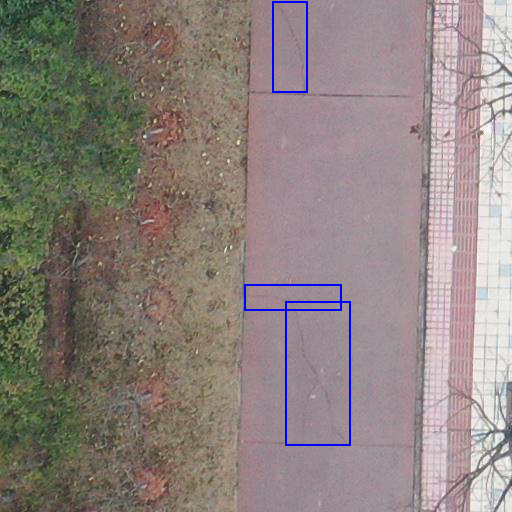

In [13]:
from PIL import Image, ImageDraw
def draw_image(img, bboxes):
    draw = ImageDraw.Draw(img)
    for bbox in bboxes:
      draw.rectangle(bbox, outline="blue", width=2)
    display(img)

def yolo_to_xml_bbox(bbox, w, h):
    # x_center, y_center width heigth
    w_half_len = (bbox[2] * w) / 2
    h_half_len = (bbox[3] * h) / 2
    xmin = int((bbox[0] * w) - w_half_len)
    ymin = int((bbox[1] * h) - h_half_len)
    xmax = int((bbox[0] * w) + w_half_len)
    ymax = int((bbox[1] * h) + h_half_len)
    return [xmin, ymin, xmax, ymax]


image_filename = "G:/ml notebooks/Road_RUL/datasets/all_images/China_Drone_000010.jpg"
filee = "G:/ml notebooks/Road_RUL/datasets/all_labels/China_Drone_000010.txt"

img = Image.open(image_filename)

bboxes=[]

with open(filee, 'r', encoding='utf8') as f:
    for line in f:
        data = line.strip().split(' ')
        bbox = [float(x) for x in data[1:]]
        bboxes.append(yolo_to_xml_bbox(bbox, img.width, img.height))

draw_image(img, bboxes)

So it is quite good as the damages are being detected. Now, Splitting the data into train-validation-test sets

In [20]:
import shutil
from tqdm import tqdm
import random

In [18]:
os.chdir("G:\ml notebooks\Road_RUL\datasets")

In [21]:
def copyfiles(fil, root_dir):
    basename = os.path.basename(fil)
    filename = os.path.splitext(basename)[0]

    # copy image
    src = fil
    dest = os.path.join(root_dir, image_dir, f"{filename}.jpg")
    shutil.copyfile(src, dest)

    # copy labels
    src = os.path.join(label_dir, f"{filename}.txt")
    dest = os.path.join(root_dir, label_dir, f"{filename}.txt")
    if os.path.exists(src):
        shutil.copyfile(src, dest)

label_dir = "all_labels/"
image_dir = "all_images/"
lower_limit = 0
files = glob.glob(os.path.join(image_dir, '*.jpg'))

random.shuffle(files)

folders = {"train": 0.8, "val": 0.1, "test": 0.1}
check_sum = sum([folders[x] for x in folders])

assert check_sum == 1.0, "Split proportion is not equal to 1.0"

for folder in folders:
    if not os.path.exists(os.path.join(os.getcwd(), folder)):
        os.mkdir(folder)
    temp_label_dir = os.path.join(folder, label_dir)
    if not os.path.exists(temp_label_dir):
        os.mkdir(temp_label_dir)
    temp_image_dir = os.path.join(folder, image_dir)
    if not os.path.exists(temp_image_dir):
        os.mkdir(temp_image_dir)

    limit = round(len(files) * folders[folder])

    # Wrap the loop with tqdm to track the progress
    with tqdm(total=limit) as pbar:
        for fil in files[lower_limit:lower_limit + limit]:
            copyfiles(fil, folder)
            pbar.update(1)  # Update progress bar

    lower_limit = lower_limit + limit


100%|██████████| 3022/3022 [00:07<00:00, 419.55it/s]
